In [23]:
import math
import torch
import hess
from hess.nets import MoonNet, Transformer
import hess.utils as utils
from hess.plotting import plot_decision_boundary
import sklearn.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

In [24]:
X, Y = datasets.make_moons(500,noise=0.3, random_state=920)

In [25]:
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

# Load Net In

In [26]:
optimus = Transformer(train_x, train_y, net=hess.nets.MoonNet, n_hidden=5, hidden_size=20,
                     activation=torch.nn.ELU(), bias=True)

In [27]:
saved_pars = torch.load("../hess/saved-models/moons2.pt")
hessian = torch.load("../hess/saved-models/moons_hessian2.pt")

In [28]:
optimus.net.load_state_dict(saved_pars)

<All keys matched successfully>

# Get the Contour

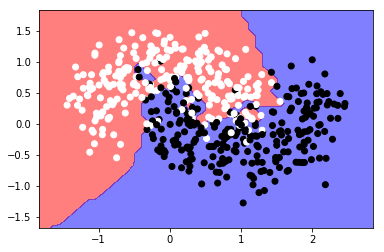

In [29]:
plot_decision_boundary(train_x, train_y, optimus,
                      buffer=0.4, h=0.1)

# Let's try some perturbations

In [30]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

In [31]:
scale = 1

In [32]:
optimus.net.load_state_dict(saved_pars)

<All keys matched successfully>

In [33]:
n_vec = 3
basis = e_vec[:, :n_vec]
wghts = torch.randn(n_vec)
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, optimus.net.parameters())
for i, par in enumerate(optimus.net.parameters()):
    par.data = par.data + perturb[i]

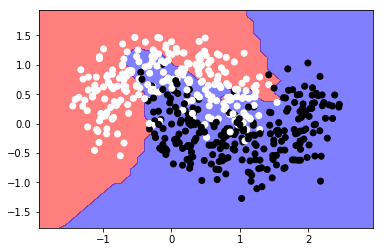

In [35]:
plot_decision_boundary(train_x, train_y, optimus,
                      buffer=0.5, h=0.1)

In [36]:
optimus.net.load_state_dict(saved_pars)

<All keys matched successfully>

In [37]:
n_vec = 50
scale = 0.75
basis = e_vec[:, -n_vec:]
wghts = torch.randn(n_vec)
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, optimus.net.parameters())
for i, par in enumerate(optimus.net.parameters()):
    par.data = par.data + perturb[i]

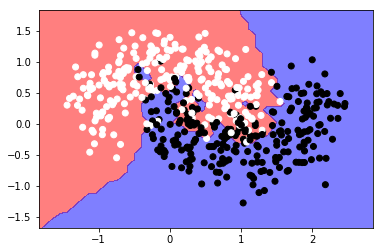

In [38]:
plot_decision_boundary(train_x, train_y, optimus,
                      buffer=0.4, h=0.1)

In [40]:
optimus.net.load_state_dict(saved_pars)

<All keys matched successfully>

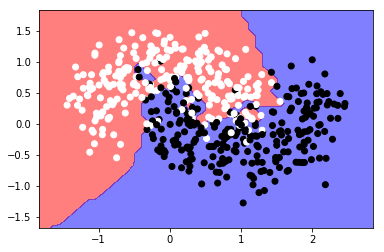

In [41]:
plot_decision_boundary(train_x, train_y, optimus,
                      buffer=0.4, h=0.1)

# Average Over Perturbations

In [42]:
buffer = 0.5
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

## Maximum Curvature

In [46]:
n_vec = 50
scale = 1
basis = e_vec[:, :n_vec]
n_trial = 500
pred = torch.zeros(in_grid.size(0), n_trial)
for tt in range(n_trial):
    optimus.net.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec)
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = optimus(in_grid).squeeze()

In [47]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

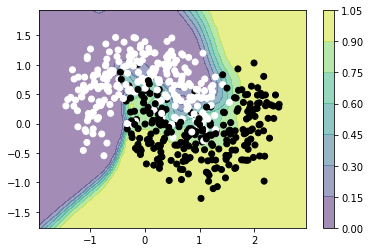

In [48]:
plt.contourf(xx, yy, avg_pred, alpha=0.5)
plt.colorbar()
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y[:, 0], cmap=plt.cm.binary)

## Minimum Curvature

In [49]:
n_vec = 50
scale = 1
basis = e_vec[:, -n_vec:]
n_trial = 500
pred = torch.zeros(in_grid.size(0), n_trial)
for tt in range(n_trial):
    optimus.net.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec)
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = optimus(in_grid).squeeze()

In [50]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

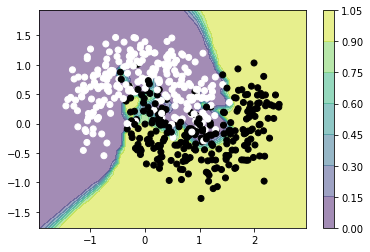

In [51]:
plt.contourf(xx, yy, avg_pred, alpha=0.5)
plt.colorbar()
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y[:, 0], cmap=plt.cm.binary)